<a href="https://colab.research.google.com/github/napoles-uach/Ai4sci/blob/main/Stiffness_Hackathon_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip install pymatgen~=2020.12
!pip install matminer==0.6.5
!pip install dgl

In [ ]:
import deepchem as dc
dc.__version__

In [4]:
import pymatgen as mg

import os
os.environ['DEEPCHEM_DATA_DIR'] = os.getcwd()

In [6]:
from pymatgen.ext.matproj import MPRester

In [15]:
import numpy as np

In [7]:
mpr = MPRester("GVKAlZWLJyoftCu7f")
data2 = mpr.query({'elasticity': {'$exists': True}}, ['material_id', 'elasticity'])

100%|██████████| 13172/13172 [00:17<00:00, 770.90it/s]


In [14]:
def mat2vec(vec):
  i = -1
  stiff_vec = []
  for row in vec:
    i=i+1
    stiff_vec+=row[i:]
  return stiff_vec

In [20]:
stiff_list = []
struc_list = []
for mat in data2:
  stiffness = mat['elasticity']['elastic_tensor']
  #id = [mat['material_id']]
  stiff_list.append(mat2vec(stiffness))
  id=mat['material_id']
  form=mpr.get_data(id)[0]['full_formula']
  comp = mg.core.Composition(form)
  #structure = mpr.get_structure_by_material_id(id)
  struc_list.append(comp)

In [21]:
X = struc_list
y = stiff_list

In [22]:
featurizer = dc.feat.ElementPropertyFingerprint()
ecfp = featurizer.featurize(struc_list)
ecfp.shape
#(5, 1024)
dataset = dc.data.NumpyDataset(X=ecfp, y=np.array(stiff_list))
len(dataset)

/usr/local/lib/python3.7/dist-packages/pymatgen/core/periodic_table.py:317: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  "avoid errors caused by the code expecting a float." % self.symbol
/usr/local/lib/python3.7/dist-packages/pymatgen/core/periodic_table.py:317: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  "avoid errors caused by the code expecting a float." % self.symbol
/usr/local/lib/python3.7/dist-packages/pymatgen/core/periodic_table.py:317: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  "avoid errors caused by the code expecting a float." % self.symbol


13172

In [23]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model = dc.models.SklearnModel(model=rf)

In [25]:
model.fit(train_dataset)

In [26]:
dc.metrics.mean_absolute_error

<function sklearn.metrics._regression.mean_absolute_error>

In [27]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)#(dc.metrics.mean_squared_error)
print("Training set score:", model.evaluate(train_dataset, [metric]))

Training set score: {'mean_absolute_error': 6.1344423001717185}


In [28]:
out=model.predict(valid_dataset)

In [29]:
tru=valid_dataset

In [30]:
import matplotlib.pyplot as plt

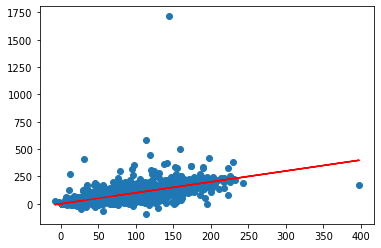

In [83]:
k=1
out_p=[]
for i in out:
  out_p.append(i[k])

out_v=[]
for i in tru.y:
  out_v.append(i[k])

plt.scatter(out_p,out_v)
plt.plot(out_p,out_p,ls='-',c='r')

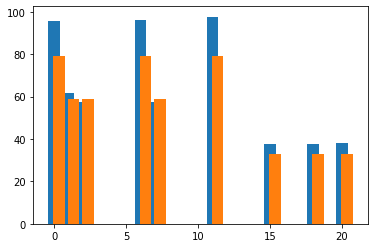

In [89]:
ind = np.arange(21)
width=0.35
i=659
fig, ax = plt.subplots()
b1 = ax.bar(ind, out[i])
b2 = ax.bar(ind+width, tru.y[i])

#ax.set_xticks(ind+width/2)
plt.show()

In [44]:
import seaborn as sns

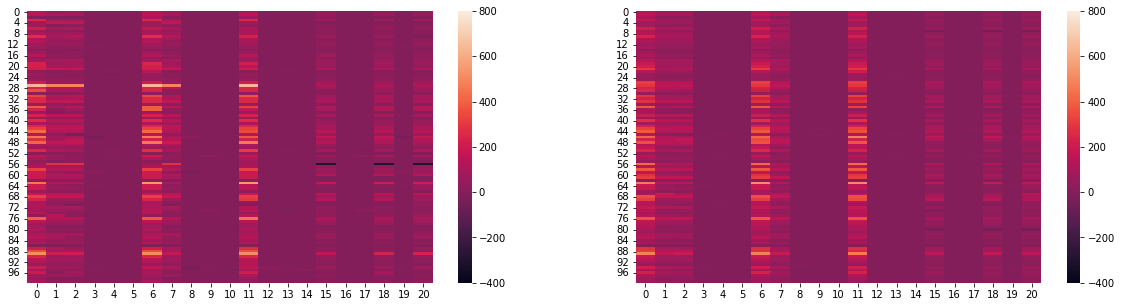

In [81]:
fig, axs = plt.subplots(ncols=2,figsize=(20,5))
sns.heatmap(tru.y[:100],ax=axs[0],vmax=800,vmin=-400)
sns.heatmap(out[:100],ax=axs[1],vmax=800,vmin=-400)
